<a href="https://colab.research.google.com/github/Asmaaad37/NeuralNetworks/blob/main/Feedforward_Neural_Networks_(FNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and Training a Feedforward Neural Network for Language Modeling

* **Tokenization & Indexing:** Converting text into numerical representations.
* **Embedding Layers:** Mapping words to dense vector representations for efficient learning.
* **Context-Target Pair Generation (N-grams):** Structuring training data for sequence prediction.
* **Multi-Class Neural Network:** Designing a model to predict the next word in a sequence.



In [61]:
!pip install -q numpy<2 pandas matplotlib seaborn scikit-learn
!pip install nltk
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install torchvision==0.17.2

/bin/bash: line 1: 2: No such file or directory


In [6]:
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE

# Section to suppress warnings generated by the code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/appli

**Feedforward Neural Networks (FNNs) for language models**

FNNs, or Multi-Layer Perceptrons, serve as the foundational components for comprehending neural networks in natural language processing (NLP). In NLP tasks, FNNs process textual data by transforming it into numerical vectors known as embeddings. Subsequently, these embeddings are input to the network to predict language facets, such as the upcoming word in a sentence or the sentiment of a text.

Let's consider the following song lyrics for our analysis.

In [7]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

In [8]:
# Tokenization for FNN - PyTorch function to obtain a tokenizer for text.
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(song)

In [9]:
def preprocess_string(s):
    """
    Preprocesses a given string by performing the following steps:

    1. Removes all non-word characters (excluding letters and numbers).
    2. Removes all whitespace characters.
    3. Removes all numeric digits.

    Parameters:
    s (str): The input string to be cleaned.

    Returns:
    str: The processed string with only alphabetic characters, no spaces, and no digits.
    """
    # Remove all non-word characters (everything except letters and numbers)
    # \w matches any word character (letters, numbers, and underscores)
    # \s matches any whitespace characters
    # ^ inside [] negates the selection, so [^\w\s] matches anything that's NOT a word character or whitespace.
    s = re.sub(r"[^\w\s]", '', s)

    # Remove all whitespace characters (spaces, tabs, newlines)
    # \s+ matches one or more whitespace characters.
    s = re.sub(r"\s+", '', s)

    # Remove all digits (0-9)
    # \d matches any digit character.
    s = re.sub(r"\d", '', s)

    return s

In [10]:
def preprocess(words):
    """
    Preprocesses a given text by tokenizing it, cleaning individual words, and
    converting them to lowercase while removing empty or punctuation tokens.

    Steps:
    1. Tokenization: Splits the input text into individual word tokens.
    2. Cleaning: Applies `preprocess_string()` to remove non-word characters,
       spaces, and digits from each token.
    3. Normalization: Converts all tokens to lowercase.
    4. Filtering: Removes empty strings and punctuation tokens.

    Parameters:
    words (str): The input text to be tokenized and preprocessed.

    Returns:
    list: A list of cleaned, lowercase tokens.
    """

    # Tokenize the input text into words
    tokens = word_tokenize(words)

    # Apply preprocessing to each token (removes unwanted characters)
    tokens = [preprocess_string(w) for w in tokens]

    # Convert tokens to lowercase and remove empty strings or punctuation
    return [w.lower() for w in tokens if len(w)!=0 and w not in string.punctuation]

# Example
tokens = preprocess(song) # Preprocess the text in 'song'

**Indexing**

TorchText provides tools to tokenize text into individual words (tokens) and build a vocabulary, which maps tokens to unique integer indexes. This is a crucial step in preparing text data for machine learning models that require numerical input.

In [11]:
def tokenizetext(song):
    """
    Tokenizes the input text (song) and builds a vocabulary from the tokens.

    Steps:
    1. Tokenization: The function splits the input text into words and applies
       a tokenizer function to each word.
    2. Vocabulary Building: Constructs a vocabulary from the tokenized words,
       including a special "<unk>" token to handle out-of-vocabulary words.
    3. Default Indexing: Sets the default index for unknown words, ensuring
       that any unseen tokens are mapped to "<unk>".

    Parameters:
    song (str): The input text (song lyrics) to be tokenized and processed.

    Returns:
    vocab (Vocab): A vocabulary object mapping tokens to their corresponding indices.
    """

    # Tokenize the text
    # Split the input text into words and apply the tokenizer function to each word.
    # The 'map' function ensures that each word is tokenized properly.
    tokenized_song = map(tokenizer, song.split())

    # Build vocabulary from tokenized text
    # The function `build_vocab_from_iterator` constructs a vocabulary by iterating
    # over the tokenized words. The special token "<unk>" is added to handle words
    # that are not present in the vocabulary.
    vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

    # Set the default index for unknown words
    # The default index is set to the index of "<unk>" so that any word not found
    # in the vocabulary is mapped to this token, preventing errors during lookup.
    vocab.set_default_index(vocab["<unk>"])

    return vocab

In [12]:
# Converting the tokens to indices
vocab = tokenizetext(song)
vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [13]:
# Text function: converts RAW text to indices
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [14]:
index_to_token = vocab.get_itos()
index_to_token[58]

'are'

**Embedding layers**

- An embedding layer is a crucial element in natural language processing (NLP) and neural networks designed for sequential data. It serves to convert categorical variables, like words or discrete indexes representing tokens, into continuous vectors. This transformation facilitates training and enables the network to learn meaningful relationships among words.

In [15]:
def genembedding(vocab):
    """
    Generates an embedding layer for the given vocabulary.

    The embedding layer transforms words into dense vector representations,
    allowing the model to learn semantic relationships between words.

    Parameters:
    vocab (Vocab): The vocabulary object containing unique words and their indices.

    Returns:
    nn.Embedding: A PyTorch embedding layer with a specified embedding dimension.
    """

    # Define the embedding dimension (size of word vectors)
    embedding_dim = 20 # Each word will be represented as a 20-dimensional vector

    # Get the vocabulary size (number of unique words in the vocabulary)
    vocab_size = len(vocab)

    # Create an embedding layer
    # The nn.Embedding module maps word indices to dense vector representations.
    # It takes vocab_size as the number of words and embedding_dim as the vector size.
    embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim)

    return embeddings

In [16]:
embeddings = genembedding(vocab)
for n in range(2):
  embedding = embeddings(torch.tensor(n))
  print("word", index_to_token[n])
  print("index", n)
  print("embedding", embedding)
  print("embedding shape", embedding.shape)

word <unk>
index 0
embedding tensor([-0.5376, -0.9978,  1.3044,  0.4863,  1.4051, -0.5307, -0.0554, -0.0972,
         0.7313, -0.4482, -0.0338,  2.0839, -1.7291,  0.0520,  1.3326, -1.4710,
         2.3910, -0.4022, -0.8394, -0.9665], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([ 0.3686, -2.0362, -0.5445,  0.5411, -0.5630, -1.6446,  0.1892,  0.5065,
         1.2831, -0.3489,  0.8167, -0.9600, -1.0914,  0.6408, -0.4041,  0.7920,
        -1.0516,  0.3238, -0.2498, -1.1703], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])


**Generating context-target pairs (n-grams)**

- Organize words within a variable-size context using the following approach: Each word is denoted by 'i'. To establish the context, simply subtract 'j'. The size of the context is determined by the value of CONTEXT_SIZE.

In [17]:
# Context for generating N-Grams
CONTEXT_SIZE = 2 # The number of previous words used to predict the next words

def genngrams(tokens):
    """
    Generates n-grams from a list of tokens, where each n-gram consists of a
    context (previous words) and a target (next word).

    The function constructs a list of tuples where:
    - The first element is a list of `CONTEXT_SIZE` previous words.
    - The second element is the target word that follows the context.

    Parameters:
    tokens (list): A list of preprocessed word tokens.

    Returns:
    list: A list of tuples representing n-grams.
          Each tuple contains (context_words, target_word).
    """

    # Generate n-grams
    # Iterate through the tokens starting from index CONTEXT_SIZE to the end
    # For each token at position 'i', extract the previous CONTEXT_SIZE words as context
    ngrams = [
        (
            [tokens[i-j-1] for j in range(CONTEXT_SIZE)],
            tokens[i] # Target Word = The word to predict
        )
        for i in range(CONTEXT_SIZE, len(tokens))
    ]

    return ngrams

In [18]:
# Output the first element, which results in a tuple. The initial element represents the context, and the index indicates the following word.
ngrams = genngrams(tokens)
context, target = ngrams[0]
print("context", context, "target", target)
print("context index", vocab(context), "target index", vocab([target]))

context ['are', 'we'] target no
context index [58, 21] target index [70]


In [19]:
embedding_dim = 20
linear = nn.Linear(embedding_dim*CONTEXT_SIZE, 128)

In [20]:
embeddings=genembedding(vocab)
my_embeddings=embeddings(torch.tensor(vocab(context)))
my_embeddings.shape

torch.Size([2, 20])

In [21]:
my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape

torch.Size([1, 40])

In [22]:
linear(my_embeddings)

tensor([[ 1.1257,  0.0050,  0.4230, -0.8576,  0.6964, -0.0244,  0.1117,  0.3231,
          1.4254, -0.2774, -0.0276, -1.2856, -0.8959, -0.1296,  0.9480, -0.4412,
         -0.0259, -0.0239, -0.3040, -0.7152,  1.2276, -0.1488,  0.4732,  0.0544,
         -0.1944,  0.4443,  0.9580,  0.6276, -0.8913,  1.0747, -0.7110,  0.3659,
          0.7405,  0.9860,  0.1839,  0.8238,  0.2128, -0.3828, -0.4460,  0.0270,
         -0.7191, -0.1684, -0.4571,  0.0148, -0.1966, -0.2324,  0.4082,  0.5416,
          0.8251,  0.0951, -0.1014, -0.2466, -0.9773, -0.6339, -0.6726, -0.6150,
          0.6076,  0.5571,  0.2351,  0.4112, -0.1415,  0.5998,  0.8868,  0.2428,
          0.3695, -1.0506, -0.6179,  0.4588,  0.4196,  1.1889,  0.4655, -0.6558,
          0.6086, -1.0208, -0.3953,  0.9060,  0.6467, -0.8610,  1.6838,  1.2146,
         -0.9748,  0.5659,  0.0383, -0.7259,  1.0281,  0.8907, -0.4202,  0.2078,
         -0.0160, -1.0341,  0.1154,  0.1532,  0.5679,  0.2125,  0.0831,  0.0533,
          0.6713, -0.1117,  

**Batch function**
- Create a Batch function to interface with the data loader. Several adjustments are necessary to handle words that are part of a context in one batch and a predicted word in the following batch.

In [23]:
from torch.utils.data import DataLoader  # Importing DataLoader for batch processing
import torch  # Importing PyTorch

# Set the device to GPU if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
CONTEXT_SIZE = 3   # Number of previous words used as context for prediction
BATCH_SIZE = 10    # Number of samples per training batch
EMBEDDING_DIM = 10 # Dimension of word embeddings

def collate_batch(batch):
    """
    Processes a batch of text data into input (context) and output (target) tensors
    for training a language model.

    The function extracts:
    - `context`: A list of word indices representing the context words for each target word.
    - `target`: A list of word indices representing the target word to predict.

    Parameters:
    batch (list): A list of tokenized words (strings).

    Returns:
    tuple: Two PyTorch tensors: (context_tensor, target_tensor)
           - context_tensor: Tensor of shape (batch_size - CONTEXT_SIZE, CONTEXT_SIZE),
             containing the word indices of context words.
           - target_tensor: Tensor of shape (batch_size - CONTEXT_SIZE,),
             containing the word indices of target words.
    """

    batch_size = len(batch)  # Get the size of the batch
    context, target = [], [] # Initialize lists for context and target words

    # Loop through the batch, ensuring enough previous words exist for context
    for i in range(CONTEXT_SIZE, batch_size):
        # Convert the target word to its index using the vocabulary
        target.append(vocab([batch[i]]))

        # Convert the previous CONTEXT_SIZE words to indices using the vocabulary
        context.append(vocab([batch[i - j - 1] for j in range(CONTEXT_SIZE)]))

    # Convert lists to PyTorch tensors and move them to the appropriate device (CPU/GPU)
    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

In [24]:
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]

In [25]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

**Multi-class neural network**
- You have developed a PyTorch class for a multi-class neural network. The network's output is the probability of the next word within a given context. Therefore, the number of classes corresponds to the count of distinct words. The initial layer consists of embeddings, and in addition to the final layer, an extra hidden layer is incorporated.

In [35]:
class NGramLanguageModeler(nn.Module):
    """
    A neural network-based n-gram language model that predicts the next word
    given a sequence of context words.

    This model consists of:
    - An embedding layer that converts word indices into dense vector representations.
    - A fully connected hidden layer with ReLU activation.
    - An output layer that predicts the probability distribution over the vocabulary.

    Parameters:
    vocab_size (int): The number of unique words in the vocabulary.
    embedding_dim (int): The size of the word embeddings (vector representation of words).
    context_size (int): The number of previous words used as context to predict the next word.
    """

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()

        # Store context size and embedding dimension
        self.context_size = context_size
        self.embedding_dim = embedding_dim

        # Embedding layer: Maps word indices to dense vectors
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Fully connected hidden layer: Maps the concatenated embeddings to a 128-dimensional space
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)

        # Output layer: Maps the hidden layer output to vocabulary size (probability distribution over words)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        inputs (Tensor): A tensor of shape (batch_size, context_size) containing word indices.

        Returns:
        Tensor: A tensor of shape (batch_size, vocab_size) representing predicted probabilities for the next word.
        """

        # Convert input word indices into dense vectors using the embedding layer
        embeds = self.embeddings(inputs)   # shape: (batch_size, context_size, embedding_dim)

        # Reshape the embeddings into a single vector per input sample
        embeds = torch.reshape(embeds, (-1, self.context_size * self.embedding_dim))
        # New shape: (batch_size, context_size * embedding_dim)

        # Apply first fully connected layer with ReLU activation
        out = F.relu(self.linear1(embeds))

        # Apply second fully connected layer to generate vocabulary-size logits
        out = self.linear2(out) # Shape: (batch_size, vocab_size)

        return out

In [36]:
# Create the model
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [37]:
# Retrieve from the data loader object and input them to the NN
context, target=next(iter(dataloader))
print(context, target)
out=model(context)

tensor([[70, 58, 21],
        [74, 70, 58],
        [25, 74, 70],
        [69, 25, 74],
        [ 2, 69, 25],
        [20,  2, 69],
        [31, 20,  2]]) tensor([74, 25, 69,  2, 20, 31, 72])


In [38]:
out.shape

torch.Size([7, 79])

In [39]:
# Find the index with the highest prob
predicted_index =torch.argmax(out,1)
predicted_index

tensor([28, 28, 21, 74, 72, 74, 53])

In [40]:
# Finding the corresponding token
[index_to_token[i.item()] for i in  predicted_index]

['i', 'i', 'we', 'strangers', 'rules', 'strangers', 'were']

In [41]:
def write_song(model, my_song, number_of_words=100):
    """
    Generates text using a trained n-gram language model.

    Given an initial text (`my_song`), the function generates additional words by
    predicting the next word iteratively based on the trained model.

    Parameters:
    model (nn.Module): The trained n-gram language model.
    my_song (str): The initial seed text to start generating words.
    number_of_words (int): The number of words to generate (default: 100).

    Returns:
    str: The generated song lyrics as a string.
    """

    # Get the mapping from index to word for decoding predictions
    index_to_token = vocab.get_itos()

    # Loop to generate the desired number of words
    for i in range(number_of_words):

        with torch.no_grad():  # Disable gradient computation for inference

            # Prepare the input context by extracting the last CONTEXT_SIZE words from tokens
            context = torch.tensor(
                vocab([tokens[i - j - 1] for j in range(CONTEXT_SIZE)])
            ).to(device)  # Move to CPU/GPU as required

            # Predict the next word by selecting the word with the highest probability
            word_idx = torch.argmax(model(context))  # Get index of the most likely next word

            # Append the predicted word to the generated text
            my_song += " " + index_to_token[word_idx.detach().item()]

    return my_song  # Return the generated lyrics

In [42]:
def pickrandomline(song):
    """
    Selects a random line from the given song text.

    This function splits the song into separate lines and randomly picks one of them.

    Parameters:
    song (str): The song lyrics as a multi-line string.

    Returns:
    str: A randomly selected line from the song.
    """

    # Split the song into individual lines
    lines = song.split("\n")

    # Randomly select a line and remove leading/trailing whitespace
    selected_line = random.choice(lines).strip()

    return selected_line  # Return the randomly selected line

# Example usage:
selected_line = pickrandomline(song)  # Pick a random line from the song

# Generate a new song starting with the selected line
generated_song = write_song(model, selected_line)

# Print the generated lyrics
print(generated_song)

Never gonna run around and desert you strangers strangers we i i we strangers rules strangers were we rules strangers ask were rules i strangers i feeling we rules strangers what your how strangers rules we i known rules inside aching we we rules inside how long a we we i how i a we strangers from what im a we strangers rules how aching a we ask rules i strangers strangers i a we we were ask im a we going love strangers a we we strangers how we strangers strangers known strangers rules love strangers wanna your strangers ask rules lie your known get were


**Training**
- Training a language model involves a multi-step process that leverages training and testing data to optimize model performance. In the realm of Natural Language Processing (NLP), this process often employs various metrics to gauge a model's accuracy, such as perplexity or accuracy on unseen data. However, in the context of your current exploration, you will embark on a slightly different journey. Instead of relying solely on conventional NLP metrics, the focus shifts to manual inspection of the results.

You have the cross entropy loss between input logits and target:

In [43]:
criterion = torch.nn.CrossEntropyLoss()

In [44]:
def train(dataloader, model,song,number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            selected_line=pickrandomline(song)
            my_song += write_song(model, selected_line)    # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [45]:
my_loss_list=[]

In [46]:
# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [47]:
my_loss=train(dataloader,model_2,song)

  3%|▎         | 3/100 [00:00<00:09, 10.00it/s]

Generated Song:


And if you ask me how Im feeling never wouldnt other <unk> lie <unk> <unk> <unk> gonna down hurt you <unk> <unk> long <unk> <unk> <unk> been <unk> youre lie <unk> <unk> <unk> lie <unk> lie lie too <unk> never <unk> <unk> you <unk> you <unk> if <unk> <unk> <unk> <unk> <unk> run <unk> <unk> lie <unk> <unk> run <unk> <unk> you <unk> never <unk> <unk> <unk> youre down <unk> lie never <unk> <unk> <unk> <unk> <unk> never been <unk> <unk> lie <unk> lie <unk> <unk> you youre lie <unk> hurt never you <unk> <unk> been <unk> <unk> <unk> youre <unk> never <unk> see <unk> hearts <unk> gonna


 15%|█▌        | 15/100 [00:01<00:05, 15.88it/s]

Generated Song:


Never gonna tell a lie and hurt you never <unk> <unk> <unk> you you <unk> never <unk> you you you you <unk> never <unk> you never <unk> <unk> <unk> <unk> <unk> <unk> <unk> never <unk> <unk> <unk> <unk> never never <unk> you you you never never you <unk> you you <unk> <unk> <unk> <unk> you you never never <unk> <unk> you you never never <unk> <unk> you you and you you never <unk> <unk> you you <unk> <unk> <unk> <unk> you you <unk> <unk> <unk> you you you <unk> <unk> you never never <unk> <unk> never <unk> <unk> you <unk> never <unk> <unk> never <unk> you <unk> you


 26%|██▌       | 26/100 [00:01<00:02, 25.05it/s]

Generated Song:


Never gonna make you cry never <unk> <unk> <unk> you you never never never you you you you <unk> never <unk> you never <unk> never <unk> and never <unk> <unk> never <unk> <unk> and <unk> never never <unk> tell you never never never you <unk> tell you never never <unk> <unk> tell you never never <unk> <unk> tell you never never <unk> <unk> tell you and desert you never <unk> <unk> tell you never and <unk> <unk> tell goodbye never <unk> <unk> tell you you and <unk> you never never <unk> <unk> and <unk> <unk> you say never never <unk> and <unk> you <unk> you


 33%|███▎      | 33/100 [00:01<00:02, 23.04it/s]

Generated Song:


Never gonna say goodbye never <unk> <unk> <unk> you you never never never been you you you <unk> and <unk> you never <unk> never and and never <unk> <unk> never <unk> <unk> and <unk> and never <unk> tell you never never never you <unk> tell you down never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you down and <unk> <unk> tell goodbye never <unk> <unk> tell you you and hurt you never never <unk> <unk> and <unk> <unk> you say been never <unk> and and you <unk> goodbye


 46%|████▌     | 46/100 [00:02<00:02, 26.73it/s]

Generated Song:


I just wanna tell you how Im feeling never <unk> desert <unk> to <unk> you never never been you you you i and <unk> you never im you and and never <unk> <unk> never <unk> <unk> and <unk> and never <unk> tell you never never feeling you <unk> tell you down never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you down and <unk> <unk> tell goodbye never <unk> <unk> tell you you and hurt you never never <unk> <unk> and <unk> <unk> you say been aching <unk> and too shy to goodbye


 55%|█████▌    | 55/100 [00:02<00:01, 24.20it/s]

Generated Song:


Never gonna make you cry never im no <unk> to <unk> you never never been you you you i and <unk> you never im feeling <unk> and never <unk> <unk> never <unk> <unk> and <unk> and never <unk> tell you never im feeling and <unk> tell you down never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you down and <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known <unk> <unk> and <unk> <unk> you say been aching but and too shy to say


 64%|██████▍   | 64/100 [00:03<00:01, 23.47it/s]

Generated Song:


Never gonna tell a lie and hurt you never im no strangers to <unk> you never never been you to you i and <unk> im never im feeling <unk> and never never <unk> never <unk> <unk> and <unk> and never <unk> tell you never im feeling and <unk> tell you down never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell goodbye and desert you never <unk> <unk> tell you down never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known <unk> <unk> and <unk> <unk> you hearts been aching but youre too shy to say


 73%|███████▎  | 73/100 [00:03<00:01, 22.43it/s]

Generated Song:


Never gonna give you up never im no strangers to <unk> you never never been you to you i and the im what im feeling <unk> and never never <unk> how <unk> <unk> and <unk> know never <unk> tell you how im feeling <unk> <unk> tell you down never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell around and desert you never <unk> <unk> tell you down never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never known each <unk> and <unk> <unk> you hearts been aching but youre too shy to say


 85%|████████▌ | 85/100 [00:03<00:00, 23.18it/s]

Generated Song:


Never gonna tell a lie and hurt you never im no strangers to <unk> you never never game you to <unk> i and the im what im feeling <unk> and never never <unk> how to <unk> and i know <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell around and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never known each other for <unk> <unk> you hearts been aching but youre too shy to say


 94%|█████████▍| 94/100 [00:04<00:00, 21.12it/s]

Generated Song:


Never gonna give you up never im no strangers to love you never the game you to <unk> i a the im what im thinking <unk> and wouldnt never <unk> how to other for i know <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell around and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never known each other for <unk> <unk> you hearts been aching but youre too shy to say


100%|██████████| 100/100 [00:04<00:00, 21.08it/s]


In [48]:
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

In [52]:
!pip install -q numpy<2 pandas matplotlib seaborn scikit-learn

/bin/bash: line 1: 2: No such file or directory


In [57]:
import numpy as np
print(np.__version__)

2.0.2


In [58]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4,song)

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  3%|▎         | 3/100 [00:00<00:03, 29.24it/s]

Generated Song:


Never gonna make you cry going <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you make <unk> <unk> <unk> <unk> <unk> <unk> <unk> youre <unk> going <unk> <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you you <unk> <unk> <unk> you you you <unk> <unk> <unk> <unk> you <unk> <unk> you <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> going <unk> <unk> <unk> going <unk> <unk> going <unk> <unk> never you goodbye <unk> <unk> <unk> you


 12%|█▏        | 12/100 [00:00<00:05, 16.44it/s]

Generated Song:


Never gonna make you cry never <unk> <unk> <unk> <unk> <unk> never you <unk> <unk> never <unk> <unk> never <unk> <unk> <unk> never never never <unk> <unk> <unk> <unk> <unk> <unk> never never never <unk> <unk> <unk> <unk> you you never <unk> feeling you <unk> <unk> you never <unk> <unk> <unk> you you never never <unk> <unk> you you never never <unk> <unk> tell you never never you never <unk> <unk> make you never never <unk> <unk> say you never <unk> <unk> tell you never <unk> <unk> you never never <unk> <unk> never never <unk> never <unk> <unk> never <unk> never <unk> never <unk> you


 24%|██▍       | 24/100 [00:01<00:04, 16.42it/s]

Generated Song:


Never gonna let you down never <unk> never <unk> to <unk> you you <unk> <unk> never <unk> <unk> never <unk> <unk> <unk> never you feeling <unk> <unk> <unk> <unk> <unk> <unk> never never never <unk> <unk> <unk> <unk> tell you down <unk> feeling you <unk> <unk> you down never <unk> <unk> tell you down never <unk> <unk> let you down never <unk> <unk> say goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you never <unk> <unk> you never you <unk> other for never <unk> never <unk> <unk> never but never <unk> shy <unk> you


 36%|███▌      | 36/100 [00:01<00:02, 23.69it/s]

Generated Song:


Never gonna say goodbye never <unk> never <unk> to <unk> you you <unk> never make were <unk> never <unk> <unk> <unk> never you feeling <unk> never <unk> <unk> <unk> <unk> never other never <unk> <unk> <unk> <unk> tell you down im feeling <unk> <unk> <unk> you down never <unk> <unk> give you down never <unk> <unk> let you down never <unk> <unk> say goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you down <unk> <unk> you never known each other for never <unk> never <unk> <unk> never but youre too shy <unk> say


 45%|████▌     | 45/100 [00:02<00:02, 22.57it/s]

Generated Song:


Never gonna say goodbye never known never <unk> to <unk> you you <unk> never make were <unk> never <unk> say <unk> you you feeling <unk> tell <unk> <unk> <unk> <unk> never other never <unk> <unk> <unk> <unk> tell you down im feeling <unk> <unk> <unk> you down never <unk> <unk> give you down never <unk> <unk> let you down never <unk> <unk> say goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you how <unk> <unk> you never known each other for never <unk> for <unk> been never but youre too shy <unk> say


 54%|█████▍    | 54/100 [00:02<00:01, 23.03it/s]

Generated Song:


I just wanna tell you how Im feeling never known never <unk> to <unk> you know the rules make were <unk> never <unk> say <unk> you im thinking <unk> tell <unk> <unk> <unk> from never other guy <unk> <unk> <unk> <unk> tell you how im feeling <unk> <unk> <unk> you down never <unk> <unk> give you down never <unk> <unk> let you down never <unk> <unk> give goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you how <unk> <unk> you never known each other for never <unk> for <unk> been aching but youre too shy to say


 66%|██████▌   | 66/100 [00:03<00:01, 23.87it/s]

Generated Song:


Never gonna run around and desert you never known no strangers to love you know the rules make were <unk> never a full <unk> you im thinking <unk> tell <unk> <unk> <unk> from any other guy i <unk> <unk> <unk> tell you how im feeling <unk> <unk> <unk> you down never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> give goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you lie <unk> <unk> you never known each other for never long for <unk> been aching but youre too shy to say


 75%|███████▌  | 75/100 [00:03<00:01, 23.76it/s]

Generated Song:


Never gonna let you down never are no strangers to love you know the rules make were <unk> never a full commitments you im thinking <unk> tell <unk> <unk> this from any other guy i <unk> <unk> <unk> tell you how im feeling <unk> <unk> <unk> you down never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> give goodbye never never you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you lie <unk> <unk> you never known each other for never long for <unk> been aching but youre too shy to say


 84%|████████▍ | 84/100 [00:04<00:00, 22.22it/s]

Generated Song:


Never gonna tell a lie and hurt you never are no strangers to love you know the rules make were <unk> never a full commitments what im thinking <unk> tell <unk> <unk> this from any other guy i <unk> to <unk> tell you how im feeling <unk> <unk> <unk> you understand never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> run goodbye never never you never <unk> <unk> make you understand never <unk> <unk> say goodbye never <unk> <unk> tell you lie and feeling you never known each other for so long for <unk> been aching but youre too shy to say


 96%|█████████▌| 96/100 [00:04<00:00, 21.42it/s]

Generated Song:


Never gonna run around and desert you never are no strangers to love you know the rules strangers were <unk> never a full commitments what im thinking <unk> tell <unk> <unk> this from any other guy i <unk> to <unk> tell you how im feeling <unk> <unk> <unk> you understand never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> run goodbye never never you never <unk> <unk> make you understand never <unk> <unk> say goodbye never <unk> <unk> tell you lie and feeling you never known each other for so long for <unk> been aching but youre too shy to say


100%|██████████| 100/100 [00:04<00:00, 20.87it/s]


In [60]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8,song)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:02, 32.44it/s]

Generated Song:


Never gonna give you up <unk> <unk> <unk> <unk> <unk> tell <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> to <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> give <unk> <unk> <unk> tell <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


 14%|█▍        | 14/100 [00:00<00:04, 20.27it/s]

Generated Song:


Never gonna let you down <unk> tell <unk> give to tell you never the give <unk> <unk> <unk> give play <unk> make you im thinking <unk> <unk> give <unk> <unk> you <unk> give guy <unk> <unk> <unk> <unk> tell you you im <unk> <unk> <unk> give you you never <unk> <unk> give you up never <unk> <unk> give you you never <unk> <unk> give you you never <unk> tell <unk> <unk> make you you never <unk> <unk> give you you <unk> <unk> tell you lie never <unk> <unk> <unk> <unk> <unk> give you so <unk> give give <unk> give tell <unk> too give to give


 24%|██▍       | 24/100 [00:01<00:04, 16.30it/s]

Generated Song:


I just wanna tell you how Im feeling <unk> tell to strangers to tell so im the rules <unk> <unk> <unk> never play <unk> make you im thinking <unk> <unk> give <unk> <unk> make <unk> give guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> <unk> to other for so long give you to give tell im too shy to say


 37%|███▋      | 37/100 [00:01<00:02, 25.48it/s]

Generated Song:


Never gonna give you up <unk> a for strangers to so so im the rules <unk> <unk> <unk> never play to make you im thinking <unk> <unk> give <unk> <unk> strangers <unk> make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a to other for so long give around to i tell im too shy to say


 45%|████▌     | 45/100 [00:02<00:01, 29.90it/s]

Generated Song:


Never gonna say goodbye <unk> a for strangers to so guy im the rules <unk> <unk> <unk> never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers <unk> make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long give around to i tell im too shy to say


 53%|█████▎    | 53/100 [00:02<00:01, 27.39it/s]

Generated Song:


Never gonna give you up <unk> a for strangers to so guy im the rules going <unk> long never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers we make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long tell around to i tell im too shy to say


 65%|██████▌   | 65/100 [00:02<00:01, 24.73it/s]

Generated Song:


A full commitments what Im thinking of <unk> a for strangers to so guy im the rules going <unk> long never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers we make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long tell around to i tell im too shy to say


 74%|███████▍  | 74/100 [00:03<00:01, 24.58it/s]

Generated Song:


I just wanna tell you how Im feeling <unk> a been strangers to so guy im the rules going <unk> long never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers we make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> run you cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long tell around to i tell im too shy to say


 86%|████████▌ | 86/100 [00:03<00:00, 25.82it/s]

Generated Song:


I just wanna tell you how Im feeling <unk> a been strangers to so guy im the rules going <unk> long never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers we make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> run around cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long tell around to i tell im too shy to say


 95%|█████████▌| 95/100 [00:04<00:00, 22.91it/s]

Generated Song:


Never gonna tell a lie and hurt you <unk> a been strangers to so guy im the rules going <unk> long never play to make you im thinking <unk> <unk> rules <unk> <unk> strangers we make guy i <unk> shy <unk> give a to im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> run around cry never <unk> <unk> run around up never <unk> tell a <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> a for other for so long tell around to i tell im too shy to say


100%|██████████| 100/100 [00:04<00:00, 23.36it/s]


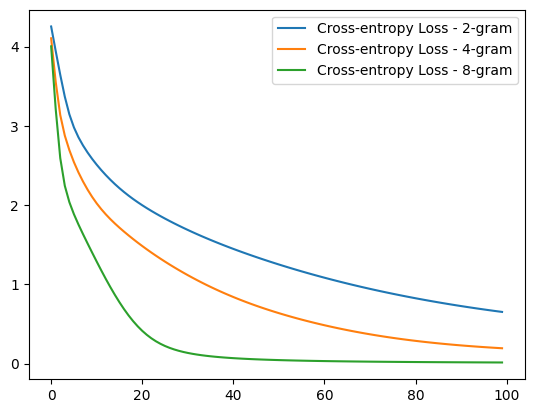

In [63]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

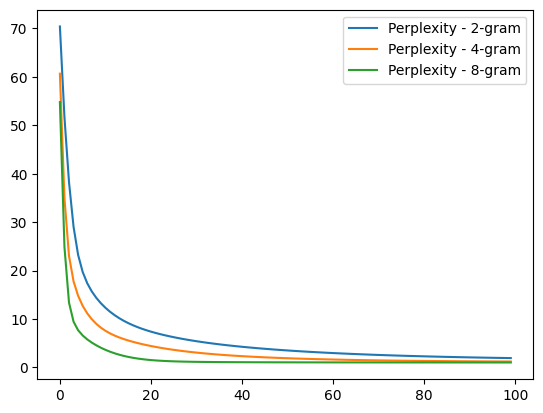

In [64]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()